In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install patchify

In [4]:
import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/classes.json
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_002.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_006.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_005.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_003.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_004.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_007.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_009.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/

In [5]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import torch
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [7]:
def create_dir(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name, exist_ok=True)

In [10]:
scaler = MinMaxScaler()
root_dir = '/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/'
patch_size = 256

In [11]:
image_dataset=[]
for path,subdirs,files in os.walk(root_dir):
    dirname = path.split(os.path.sep)[-1]
    if dirname =="images":
        images = os.listdir(path)
        for i,image_name in enumerate(images):
            if image_name.endswith(".jpg"):
                image = cv2.imread(path+'/'+image_name,cv2.IMREAD_COLOR)
                # Crop
                # Height Width Channel
                SIZE_X = (image.shape[1]//patch_size)*patch_size 
                SIZE_Y = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image)
                image = image.crop((0,0,SIZE_X,SIZE_Y))
                
                image = np.array(image)
                
                patches_img = patchify(image,(patch_size,patch_size,3),step=patch_size)
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i,j,:,:]
                        # img need flatten
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
                        image_dataset.append(single_patch_img)
                

In [12]:
mask_dataset =[]
for path,subdirs,files in os.walk(root_dir):
    dirname = path.split(os.path.sep)[-1]
    if dirname == "masks":
        masks = os.listdir(path)
        for i,mask_name in enumerate(masks):
            if mask_name.endswith(".png"):
                mask = cv2.imread(path+'/'+mask_name,1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0,0,SIZE_X,SIZE_Y))
                mask = np.array(mask)
                
                patches_mask = patchify(mask,(patch_size,patch_size,3),step = patch_size)
                
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]
                        mask_dataset.append(single_patch_mask)
        

In [13]:
image_dataset =np.asarray(image_dataset)
mask_dataset =np.asarray(mask_dataset)
image_dataset.shape

(1305, 256, 256, 3)

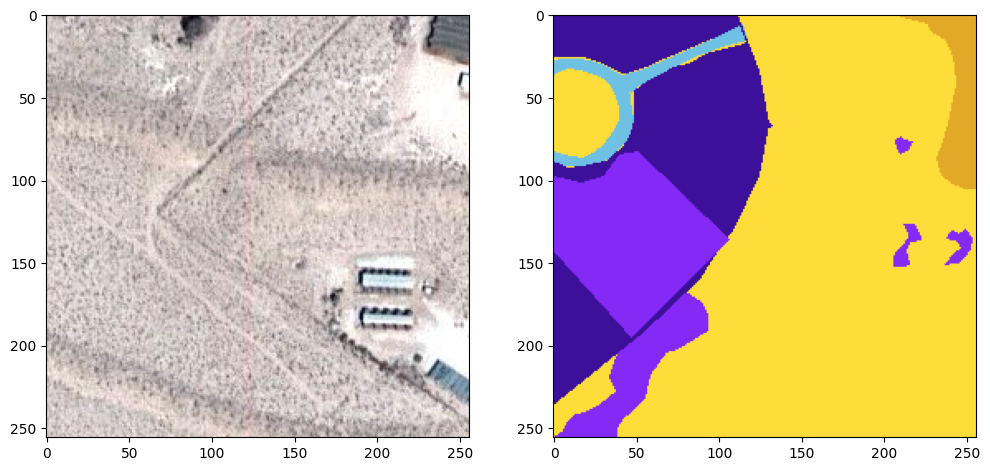

In [14]:
import random
import numpy as np
image_number = random.randint(0,len(image_dataset))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [15]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4)))

In [16]:
def rgb_to_2D_label(label,num_class=6):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0] 
    
    new_label = np.zeros(label_seg.shape + (num_class,))
    
    
    
    for i in range(num_class):
        new_label[label_seg == i,i] = 1   
    label_seg=new_label
    
    return label_seg

In [17]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)
    

labels = np.array(labels)


In [18]:
image_dataset[0].shape,labels.shape

((256, 256, 3), (1305, 256, 256, 6))

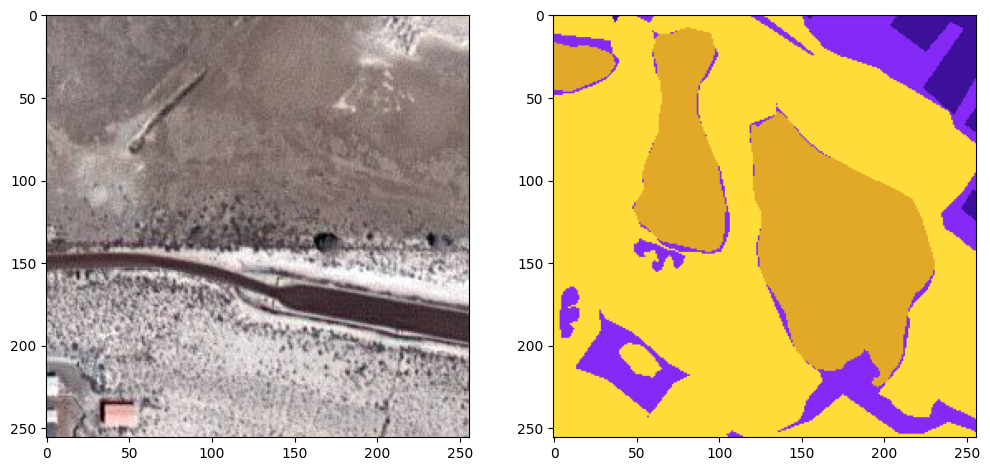

In [19]:
image_number = random.randint(0,len(image_dataset))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [21]:
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
class Aerial(Dataset):
    def __init__(self,images,maskes):
        super(Aerial,self).__init__()
        self.images = images
        self.masks = maskes
        self.n_samples =len(images) 
        
    
    def __getitem__(self,index):
        image = self.images[index]
        image = image/255.0
        image = np.transpose(image,(2,0,1))
        image = image.astype(np.float32)
        image = torch.from_numpy(image)
        
        mask = self.masks[index]
        mask = np.transpose(mask,(2,0,1))
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)
        
        return image,mask
    def __len__(self):
        return self.n_samples

In [22]:
create_dir("files/")
create_dir("Results/")
H = 256
W =256
num_class = len(np.unique(labels))
size =(H,W)
batch_size =2
num_epochs = 100
lr=1e-4
checkpoints_path ="files/checkpoints.pth"

In [25]:
from sklearn.model_selection import train_test_split
train_x,val_x,train_y,val_y = train_test_split(image_dataset,labels,test_size=0.2, random_state = 42)

train_dataset = Aerial(train_x,train_y)
val_dataset = Aerial(val_x,val_y)

In [27]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle = True,
    num_workers=2,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

In [54]:
import torch.nn as nn
import torch
import torchvision


class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),  
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UNet, self).__init__()
        self.conv1 = DoubleConv(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2) 
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)

        self.conv10 = nn.Conv2d(64, out_ch, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)  
        c6 = self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9)
        c10 = self.conv10(c9)

        out = self.sigmoid(c10)
        return out

In [56]:
import torch
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1.0

        iflat = input.reshape(-1)
        tflat = target.reshape(-1)
        intersection = (iflat * tflat).sum()

        dice_loss = 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

        return dice_loss

    def calculate_average_dice_loss(self, inputs, targets):
        num_channels = inputs.size(1)

        dice_losses = []
        for channel in range(num_channels):
            input_channel = inputs[:, channel, ...].unsqueeze(1)
            target_channel = targets[:, channel, ...].unsqueeze(1)
            dice_loss_channel = self.forward(input_channel, target_channel)
            dice_losses.append(dice_loss_channel)

       
        average_dice_loss = torch.mean(torch.stack(dice_losses))

        return average_dice_loss

In [57]:
model = UNet(3,6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
loss_fn = DiceLoss()

In [58]:
from tqdm import tqdm
def train(model,loader,loss_fn,optimizer,device):
    epoch_loss=0.
    model.train()
    
    for x,y in tqdm(loader):
        x =x.to(device,dtype = torch.float32)
        y = y.to(device,dtype = torch.float32)
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn.calculate_average_dice_loss(outputs, y)
        loss.backward()
        optimizer.step()
        epoch_loss +=loss.item()
    
    return epoch_loss/len(loader)

In [61]:
def validate(model,loader,loss_fn,device):
    epoch_loss = 0.0
    model.eval()
    with torch.no_grad():
        for x,y in loader:
            x =x.to(device,dtype = torch.float32)
            y = y.to(device,dtype = torch.float32)
            outputs = model(x)
            loss = loss_fn.calculate_average_dice_loss(outputs, y)
            epoch_loss +=loss.item()
            
    return epoch_loss/len(loader)
        

In [ ]:
REAL_img_path = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 6/masks/image_part_001.png"
img_path = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 6/images/image_part_001.jpg"  

In [51]:
def label_to_rgb(predicted_image):
    
    Building = '#3C1098'.lstrip('#')
    Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) 
    Land = '#8429F6'.lstrip('#')
    Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) 
    
    Road = '#6EC1E4'.lstrip('#') 
    Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) 
    
    Vegetation =  'FEDD3A'.lstrip('#') 
    Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) 
    
    Water = 'E2A929'.lstrip('#') 
    Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) 
    
    Unlabeled = '#9B9B9B'.lstrip('#') 
    Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) 
    
    
    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))
    
    segmented_img[(predicted_image == 0)] = Building
    segmented_img[(predicted_image == 1)] = Land
    segmented_img[(predicted_image == 2)] = Road
    segmented_img[(predicted_image == 3)] = Vegetation
    segmented_img[(predicted_image == 4)] = Water
    segmented_img[(predicted_image == 5)] = Unlabeled
    
    segmented_img = segmented_img.astype(np.uint8)
    return(segmented_img)

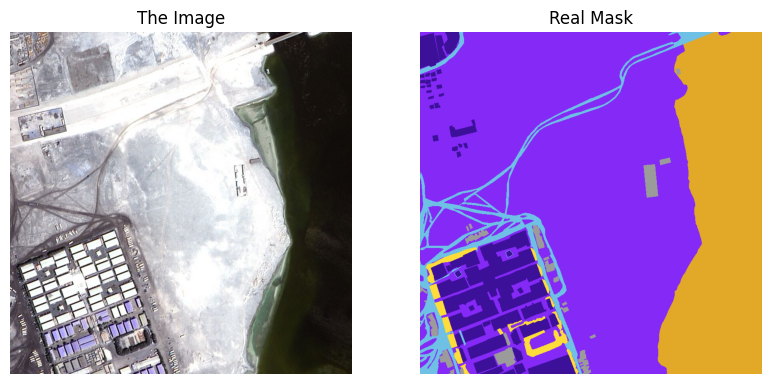

In [64]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt



G_img = Image.open(img_path)
REAL_img = Image.open(REAL_img_path)


patch_size = 256
SIZE_X = (G_img.size[0] // patch_size) * patch_size
SIZE_Y = (G_img.size[1] // patch_size) * patch_size
G_img = G_img.crop((0, 0, SIZE_X, SIZE_Y))
G_img = np.array(G_img)


patch_size = 256
SIZE_X = (REAL_img.size[0] // patch_size) * patch_size
SIZE_Y = (REAL_img.size[1] // patch_size) * patch_size
REAL_img = REAL_img.crop((0, 0, SIZE_X, SIZE_Y))
REAL_img = np.array(REAL_img)
REAL_img = np.array(REAL_img)




plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(G_img)
plt.title("The Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(REAL_img)
plt.title("Real Mask")
plt.axis('off')



plt.show()